### Скачиваем список моделей, формируем файл с нужным количеством и делаем из него массивы со случайными проницаемостями

In [ ]:
!wget --directory-prefix=/content/model_list/ https://raw.githubusercontent.com/Loop3D/noddyverse/1.0/model_list/models.csv

--2023-11-21 08:47:03--  https://raw.githubusercontent.com/Loop3D/noddyverse/1.0/model_list/models.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94870359 (90M) [text/plain]
Saving to: ‘/content/model_list/models.csv’

models.csv          100%[===================>]  90.47M   218MB/s    in 0.4s    

2023-11-21 08:47:05 (218 MB/s) - ‘/content/model_list/models.csv’ saved [94870359/94870359]



In [ ]:
import numpy as np
import pandas as pd
import h5py
import os
from tqdm.notebook import tqdm
from datetime import datetime

CURR_DIR = os.getcwd()
available_types = ['FAULT', 'SHEAR-ZONE', 'FOLD', 'TILT', 'UNCONFORMITY', 'DYKE', 'PLUG']

### Функция для выгрузки моделей с определённой историей деформирования
(с) https://github.com/Loop3D/noddyverse.git

In [ ]:
import random
import gzip
from urllib.request import urlopen

def display_models(his_filter, display_number):
    # download file, ungzip and stuff into numpy array
    def get_gz_array(url, skiprows):
        my_gzip_stream = urlopen(url)
        my_stream = gzip.open(my_gzip_stream, 'r')
        return (np.loadtxt(my_stream, skiprows=skiprows))

     # !!! Добавила распарсивание g00 файла
    def get_gz_array_g00(url, skiprows):
        my_gzip_stream = urlopen(url)
        my_stream = gzip.open(my_gzip_stream, 'r')
        return my_stream

    def create_rock_type_dict(my_stream):
        rock_types_id = {}
        for line in my_stream:
            if "ROCK DEFINITION" in str(line):
                rock_type = str(line).split(" ")[2][0:-3]
                rock_type_number = int(str(line).split(" ")[-1][0:-3])
                if rock_type in rock_types_id:
                    rock_types_id[rock_type].append(rock_type_number)
                else:
                    rock_types_id[rock_type] = [rock_type_number]

        return rock_types_id

    url = 'https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2f'
    used = []
    z = 0
    fail = 0
    models_list = []
    models_names_list = []
    models_types_id_list = [] # добавляем идентификацию типов
    models = pd.read_csv(f'{CURR_DIR}/model_list/models.csv')

    models2 = models[
        models['event03'].str.contains(his_filter[0])
        & models['event04'].str.contains(his_filter[1])
        & models['event05'].str.contains(his_filter[2])]
    models2 = models2.reset_index(drop=True)

    model_number2 = len(models2)
    if (model_number2):
        print("sampling from", model_number2, "models matching filter", his_filter)
    else:
        print("no models found with filter", his_filter, "check list syntax and spelling of events")
        return ()

    while z < display_number and fail < 1000:
        ran = random.randint(0, model_number2 - 1)
        if (ran in used):
            continue
        else:
            used.append(ran)

        file_split = models2.iloc[ran]['root'].split('/')
        tail = models2.iloc[ran]['event03'] + '_' + models2.iloc[ran]['event04'] + '_' + models2.iloc[ran][
            'event05'] + '&files='
        root = url + tail + file_split[2]
        path = root + '.g12.gz'
        mod = get_gz_array(path, skiprows=0)
        mod2 = mod.reshape((200, 200, 200))
        mod2 = np.transpose(mod2, (1, 2, 0)) # HERE!!!!
        # print(ran, file_split[2], 'STRATIGRAPHY TILT', models2.iloc[ran]['event_all'])
        models_list.append(mod2)
        models_names_list.append(models2.iloc[ran]['event_all']+'_'+str(ran))

        path_g00 = root + '.g00.gz'
        g00_file = get_gz_array_g00(path_g00, skiprows=0)
        rock_types_id = create_rock_type_dict(g00_file)
        models_types_id_list.append(rock_types_id)

        z = z + 1

    return models_list, models_names_list, models_types_id_list

### Скачиваем нужное количество моделей и складываем в h5 файл

In [ ]:
N = 1 # количество моделей

model_file_name = 'labeles' # имя для файла

model_path = f'{CURR_DIR}/{model_file_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # готовим ссылку, чтобы было больше порядка
with h5py.File(model_path, 'w') as f:
    f.create_dataset("models", (N, 200, 200, 200), dtype='i8') # нам нужны инты

    names = []
    types_id = []
    for ii in tqdm(range(N)):
        his_filter =  np.random.choice(available_types, 3)
        his_filter = ['FOLD', 'FOLD', 'FOLD'] # !!!! в этом месте мы перезадали историю, чтобы она была именно такая, внимание !!!! <><><><><><>
        models_list, models_names_list, models_types_id_list = display_models(his_filter, 1)
        f["models"][ii] = models_list[0] # семплируем по одной модели с каждой историей
        names.append({'name': models_names_list[0]})
        types_id.append(models_types_id_list[0])

    names_df = pd.DataFrame(data = names)
    types_id_df = pd.DataFrame(data = types_id)
    types_id_df_noNaN = types_id_df.fillna(0)

names_df.to_hdf(model_path, '/names')
types_id_df_noNaN.to_hdf(model_path, '/types_id')

  0%|          | 0/1 [00:00<?, ?it/s]

sampling from 8040 models matching filter ['FOLD', 'FOLD', 'FOLD']


<ipython-input-4-00eb33a11a4f>:24: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Meta_Ultramaf', 'Meta_Carb', 'Marble', 'Meta_Felsic', 'Gneiss'], dtype='object')]

  types_id_df_noNaN.to_hdf(model_path, '/types_id')


## тут можно посмотреть на геологическую модельку

In [ ]:
import plotly.graph_objects as go
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator

nnn = 0
def downscale(inp, factor):
    '''
    Считается бегущее среднее по всем точкам массива, чтобы в конечный массив попадала
    средняя проницаемость, а не точно такая, какая была в точке. Чтобы немного
    подровнять среднии проницаемости по области
    После этого берётся каждая какая то точка, какая - задаётся кортежом factor

    '''
    avg_inp = ndimage.uniform_filter(inp.astype('float32'), size=factor, mode='nearest') # усреднение

    x,y,z = (np.arange(0,k,1) for k in avg_inp.shape) # старая сетка
    interp = RegularGridInterpolator((x,y,z), avg_inp) # обьект - интерполятор

    kx,ky,kz = (np.arange(0,k,f) for k, f in zip(avg_inp.shape, factor)) # новая сетка
    m1, m2, m3 = np.meshgrid(kx, ky, kz, indexing='ij') # мешгрид
    out = interp((m1, m2, m3)) # новый массив
    return out

with h5py.File(model_path, 'r') as src:
    model = downscale(src['/models'][nnn], (10,10,10))

    X, Y, Z = np.indices(np.array(model.shape)) # тут просто коры
    dx, dy, dz = 200, 200, -200 # метров в ячейке
    X = X*dx
    Y = Y*dy
    Z = Z*dz # глубина

    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=model.flatten(),

        opacity=0.3, # прозрачность
        surface_count=21, # needs to be a large number for good volume rendering
        ))

    fig.show()

### Делаем модели с проницаемостями

In [ ]:
perm_file_name = 'perms' # имя для файла с проницаемостями
from random import randint
import random

#k_list = 10 ** (2 * np.random.rand(15).astype(np.float16)) # случайные  значения проницаемостей от 1 до 100 мД

rock_types = {'Tuff_Lapillist':'met_strat', 'Andesite':'met_strat',
    'Maf_Dyke_Sill':'dyke', 'V_Conglomerate':'met_strat', 'V_Siltstone':'met_strat',
    'V_Breccia':'met_strat', 'Ign_V_Breccia':'met_strat', 'Dacite':'met_strat', 'Basalt':'met_strat',
    'Fels_Dyke_Sill':'dyke', 'Meta_Intermed':'met_strat', 'Gneiss':'met_strat',
    'Meta_Ultramaf':'met_strat', 'Rhyolite':'met_strat', 'Limestone':'strat', 'Sandstone':'strat',
    'Conglomerate':'strat', 'Phyllite':'strat', 'Greywacke':'strat', 'Meta_Felsic':'met_strat',
    'Meta_Carb':'met_strat', 'Schist':'met_strat', 'Pelite':'strat', 'Marble':'met_strat', 'V_Sandstone':'met_strat',
    'Meta_Sediment':'met_strat', 'Meta_Mafic':'met_strat', 'Syenite':'plug', 'Pyxen_Hbnd':'plug',
    'Diorite':'plug', 'Peridotite':'plug', 'Porphyry':'plug', 'Amphib':'met_strat', 'Granite':'plug',
    'Gabbro':'plug'}

def define_types_permeability(rock_types):
    types_permeability = {} # в мДарси
    types_youngs_module = {} # ГПа
    types_poisson_ratio = {}
    types_density = {} # кг/м3
    for elem in rock_types:
        if rock_types[elem] == 'strat':
            types_permeability[elem] = randint(10, 100)
            types_youngs_module[elem] = 20
            types_poisson_ratio[elem] = 0.3
            types_density[elem] = 2600
        elif rock_types[elem] == 'met_strat':
            types_permeability[elem] = randint(1, 10)
            types_youngs_module[elem] = 20
            types_poisson_ratio[elem] = 0.3
            types_density[elem] = 2800
        elif rock_types[elem] == 'plug' or rock_types[elem] =='dyke':
            types_permeability[elem] = 10**(random.random()-3)
            types_youngs_module[elem] = 20
            types_poisson_ratio[elem] = 0.3
            types_density[elem] = 2900
    return types_permeability, types_youngs_module, types_poisson_ratio, types_density

types_permeability, types_youngs_module, types_poisson_ratio, types_density = define_types_permeability(rock_types)

def define_model_property(model, types_id_reverse, types_permeability):
    # model - трехмерный массив чисел. Каждой число характеризует конкретную породу
    # types_id_revers - словарь, относящийся к одной конкретной модели, в которм ключами являются числа из модели
    # а значениями - название горной породы.
    # types_permeability - словарь: ключи - тип горной породы, значения - проницаемость этой горной породы
    model_perm = np.zeros(np.shape(model))
    # for z in range(np.shape(model)[2]):
    #     for y in range(np.shape(model)[1]):
    #         for x in range(np.shape(model)[0]):
    #             model_perm[x][y][z] = types_permeability[types_id_reverse[model[x][y][z]]]
    for key in types_id_reverse:
      model_perm[model[:]==key] = types_permeability[types_id_reverse[key]]

    return model_perm
'''
Маш, я тебя умоляю, не итерируйся по размерностям модели! Это неправильно и дико неэффективно!
Ну там же ниже сделано то же самое через слайсы, сделай, пожалуйста, так же!
Итерируешься про списку с метками, делаешь : model_perm[model==метка] = types_permeability[types_id_reverse[метка]]
всё.
Пожааааааааааалуйста!

'''

perm_path = f'{CURR_DIR}/{perm_file_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5'
with h5py.File(perm_path, 'w') as targ:
    with h5py.File(model_path, 'r') as src:
        models = src['/models']
        types_id = pd.read_hdf(model_path, '/types_id')
        targ.create_dataset("perms", models.shape, dtype='float16') # флоат 16 чтобы поменьше был файл
        targ.create_dataset("youngs", models.shape, dtype='float16') # флоат 16 чтобы поменьше был файл
        targ.create_dataset("poissons", models.shape, dtype='float16') # флоат 16 чтобы поменьше был файл
        targ.create_dataset("density", models.shape, dtype='float16')
        #print(types_id)
        for i in range(models.shape[0]):
            mm = models[i]
            types_id_reverse = {}
            #print(types_id)
            for rock_type in types_id:
                if types_id[rock_type][i] != 0:
                    for elem in types_id[rock_type][i]:
                        types_id_reverse[elem] = rock_type

            model_perm = define_model_property(mm, types_id_reverse, types_permeability)
            model_youngs = define_model_property(mm, types_id_reverse, types_youngs_module)
            model_poisson = define_model_property(mm, types_id_reverse, types_poisson_ratio)
            model_density = define_model_property(mm, types_id_reverse, types_density)
            targ["perms"][i] = model_perm
            targ["youngs"][i] = model_youngs
            targ["poissons"][i] = model_poisson
            targ["density"][i] = model_density

        '''
        на всякий случай итерируемся по списку моделей, хотя можно было сразу сделать так:

        for jj, k in enumerate(k_list):
            perms[models[:]==jj] = k

        но не уверен что models[:] всегда и точно влезет в память

        при этом приходится делать промежуточные массивы mm и pp, так как присваивание
        значения слайсу h5 файлов не понимает двойного индексирования типа
        dset[0][1] = 3.0  # No effect!
        можно только
        dset[0, 1] = 3.0
        '''
        '''
        for ii in tqdm(range(models.shape[0])):
            mm = models[ii]
            pp = np.zeros_like(mm, dtype='float16')
            # итерируемся по списку метка - проницаемость и присваем слайсам модели соответствующие значения
            for jj, k in enumerate(k_list):
                pp[mm==jj] = k

            perms[ii] = pp


        # расшифровку меток проницаемостей сохраняем на всякий случай
        targ.create_dataset("k_list", k_list.shape, dtype='float16')
        targ['/k_list'][:] = k_list
        '''

In [ ]:
# и вот наш файл с проницаемостями
with h5py.File(perm_path, 'r') as f:
    perm = f['/perms'][0]
    poisson = f['/poissons'][0]
    youngs = f['/youngs'][0]
    dens = f['/density'][0]
# print(perm)
# print(poisson)
# print(youngs)
# print(dens)

## Теперь считаем поле порового давления при закачке

In [ ]:
# установка пай-пде
!pip install py-pde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
# импорты
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import pde
from pde import DiffusionPDE, ScalarField, UnitGrid, MemoryStorage, movie, PDE, CartesianGrid, VectorField, CylindricalSymGrid
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.widgets import TextBox

In [ ]:
class BaseConfig:
    def __init__(self, **kwargs):
        # параметры модели
        self.points = 200 # изначально модель 200х200х200 точек
        self.side_lenght = (4000, 4000, 4000) #масштаб модели в метрах - сторона куба 4 км
        self.downscale_factor = (1, 1, 1) # во сколько раз уменьшить начальное количество точек по каждой оси при даунскейле
        self.time_scale = 3600 # масштаб по времени, сек

        # параметры расчёта
        self.t_range = 100 # продолжительность расчёта, измеряется относительно self.time_scale
        self.dt = 0.001 # dt, измеряется относительно self.time_scale

        # начальное давление
        self.P0 = 10e-8 # начальное пластовое давление в МПа

        # расход
        self.Q = 10/3600 # м3/с

        # параметры среды
        self.m0 = 0.2 # начальная пористость
        self.mu = 2 # вязкость сантиПуаз (у воды 1 сантиПуаз)
        self.K_ro = 10**4 # МПа  dP = K_ro * (dro/ro0)  - модуль обьёмного сжатия жидкости (ro0 - начальная плоность)
        self.K_m = 10**4 # МПа  dP = K_m * (dm/m0) - модуль обьёмного сжатия пористости (m0 - начальная порситость)

        self.__dict__.update(kwargs) # добавляем параметры, переданные при инициализации

    def __repr__(self) -> str:
        return str(self.__dict__)

def get_xi(perm, params):
    '''
    Функция для подсчёта коэффициента диффузии. Подробности - Баренблатт стр.19
    Размерности:
    1 Мпа = 10**7 г/см*с2
    1 мД = 10**-11 см2
    1 сПз = 10**-2 г/см*с
    Итого размерность [xi] = [мД]*[МПа]/[сПз] =
                           =  10**-11 [см2] * 10**7 [г/см*с2] / 10**-2 [г/см*с] =
                           =  10**-2 [см2/с]
                           =  10**-6 [м2/с]
    Таким образом:
    '''
    xi = 10**-6 * perm / (params.m0 * params.mu * (1/params.K_ro + 1/params.K_m)) # м2/с
    return xi * params.time_scale # пересчёт на размерность веремени модели

def get_p0_1(perm, params):
    '''
    постоянное начальное давление
    '''
    return np.ones_like(perm) * params.P0

def get_p0_2(perm, params):
    N_x, N_y, N_z = np.shape(perm)
    X, Y, Z = params.side_lenght
    delta_z = Z/N_z
    p0 = np.zeros((N_x, N_y, N_z))
    for n_z in range(N_z):
      p0_xy = np.ones((N_x, N_y))*9.8*1000*(n_z)*delta_z/1000000
      p0[:, :, N_z-n_z-1] = p0_xy

    return p0

def get_source(params):
    '''
    возвращает значение источника:
    скорость изменение давления на скважине, если нет фильтрации, по отношению к шагу по времени
    Тут нужно всё аккуратно подобрать, потому что есть мнение, чтоэто не на скважине давление так меняется,
    а на 1 элементе сетки, то есть в кубике сколько то м3
    dP/dt ~ K_m * ((dv/dt)/V) - изменение давления при закачке dv жидкости в объём V
    '''
    # x_length, y_length, z_length = params.side_lenght
    # dx, dy, dz = (l*f/params.points for l,f in zip(params.side_lenght, params.downscale_factor))
    # V = dx * dy * dz * params.m0 # суммарный обьём пор элемента среды в кубометрах
    V = 3.1415 * 0.1**2 / 4 * 2000 # объём "скважины"
    dP = params.K_ro * params.Q / V # изменение давления, МПа/с
    return dP * params.time_scale # изменение давления за шаг по времени

def downscale(inp, factor):
    '''
    Считается бегущее среднее по всем точкам массива, чтобы в конечный массив попадала
    средняя проницаемость, а не точно такая, какая была в точке. Чтобы немного
    подровнять среднии проницаемости по области
    После этого берётся каждая какая то точка, какая - задаётся кортежом factor

    '''
    avg_inp = ndimage.uniform_filter(inp.astype('float32'), size=factor, mode='nearest') # усреднение

    x,y,z = (np.arange(0,k,1) for k in avg_inp.shape) # старая сетка
    interp = RegularGridInterpolator((x,y,z), avg_inp) # обьект - интерполятор

    kx,ky,kz = (np.arange(0,k,f) for k, f in zip(avg_inp.shape, factor)) # новая сетка
    m1, m2, m3 = np.meshgrid(kx, ky, kz, indexing='ij') # мешгрид
    out = interp((m1, m2, m3)) # новый массив
    return out.astype('float16')


# def source_location(perm):
#     N, M, L = np.shape(perm)
#     perm_in_the_mid = perm[round(N/2),round(M/2),:] # проницаемость с глубиной в центре
#     array_where = np.argwhere(perm_in_the_mid==np.max(perm_in_the_mid))
#     #D = np.median(array_where) # примерно середина области с проницаемостью 3.
#     # Скорее всего слой будет один с такой проницаемостью, так что не промахнемся
#     D = array_where[round(len(array_where)/2)-1]
#     print(D)
#     Bore_xyz = [round(N/2),round(M/2), int(D)] # координаты скважины
#     print('source_location - ', Bore_xyz)
#     plt.plot(perm_in_the_mid)
#     plt.show()

#     return Bore_xyz

def source_location(perm, params):
    N, M, L = np.shape(perm)
    X, Y, Z = params.side_lenght
    delta_x, delta_y, delta_z = X/N, Y/M, Z/L
    perm_in_the_mid_block = perm[round(N/4):round(3*N/4),round(M/4):round(3*M/4),round(L/4):round(3*L/4)]
    N_block, M_block, L_block = np.shape(perm_in_the_mid_block)
    N_block_center, M_block_center, L_block_center = N_block/2, M_block/2, L_block/2
    array_3D_where = np.argwhere(perm_in_the_mid_block == np.max(perm_in_the_mid_block))
    if np.shape(array_3D_where)[0] == 0:
      array_3D_where = np.argwhere(perm_in_the_mid_block > 1)
      if np.shape(array_3D_where)[0] == 0:
        print("no permeability with values > 1")
        raise ValueError

    dist_list = [(((point[0] - N_block_center)*delta_x)**2 + ((point[1] - M_block_center)*delta_y)**2 + ((point[2] - L_block_center)*delta_z)**2)**0.5 for point in array_3D_where]
    min_dist_list = min(dist_list)
    min_dist_indices = [i for i in range(len(dist_list)) if dist_list[i] == min_dist_list]
    perms_with_min_dist = [perm_in_the_mid_block[array_3D_where[i][0], array_3D_where[i][1], array_3D_where[i][2]] for i in min_dist_indices]
    max_perm_with_min_dist = max(perms_with_min_dist)
    for i in range(len(perms_with_min_dist)):
      if perms_with_min_dist[i] == max_perm_with_min_dist:
        index = min_dist_indices[i]
        Bore_xyz = [round(N/4)+array_3D_where[index][0], round(M/4)+array_3D_where[index][1], round(L/4)+array_3D_where[index][2]]
        break
    # print("Bore_xyz-", Bore_xyz)
    # print("perm-", max_perm_with_min_dist)

    return Bore_xyz
    '''
    ><><><><><><><><><>>>>><><><><><><><><><><><><><><><><> ВНЕИМАНИЕ!!!! Тут испорчено! Возвращает всегда одно и то же!!!! <><><><><><><><><><><><><><><><><><><> <<<<<=========================================== !!!!!!!!!!!
    '''
    # return [25,25,25]      # чтобы вернуть как было, надо раскомметить предыдущий return а этот стереть


def find_pore_pressure_1(perm, params):
    '''
    вычисление порового давления
    '''
    x_length, y_length, z_length = params.side_lenght # длины сторон куба в метрах
    grid = CartesianGrid([[0, x_length], [0, y_length], [0, z_length]], perm.shape)  # generate grid

    #delta_x, delta_y, delta_z = [a*b for a, b in zip(params.side_lenght/params.points, params.downscale_factor)]
    delta_x = x_length/perm.shape[0]
    delta_y = y_length/perm.shape[1]
    delta_z = z_length/perm.shape[2]

    p0 = get_p0_1(perm, params) # начальное пластовое давление
    pore_pressure_field = pde.ScalarField(grid, data=p0)

    source = f"{get_source(params)}"  # скорость изменение давления на скважине, если нет фильтрации
    print(f'источник {source}')
    point = ScalarField(grid, data=0)
    source_loc_cells = source_location(perm, params)
    source_loc_real = [delta_x * source_loc_cells[0], delta_y * source_loc_cells[1], delta_z * source_loc_cells[2]]
    point.insert(source_loc_real, 1)  # скважина
    # source = f"sin(2*pi*{10}*t)" # давление на скважине как то меняется или...

    '''
    Вставить функцию добавления асбсолютно проницаемых и непроницаемых включений
    '''

    xi = get_xi(perm, params) # к-т диффузии
    print(f'хи {np.mean(xi)}')
    xi_field = ScalarField(grid, data=xi)

    # bc = {'value': Pres}
    bc_x_left = {"value": params.P0}
    bc_x_right = {"value": params.P0}
    bc_x = [bc_x_left, bc_x_right]
    # bc_y = {"derivative": 0}
    bc_y = {"value": params.P0}
    bc_z = {"value": params.P0}
    bc = [bc_x, bc_y, bc_z]

    eq = PDE({'u': f"xi*laplace(u) + {source}*point"}, bc=bc,
             consts={'point': point, 'xi': xi_field})  # уравнение диффузии с источником

    storage = MemoryStorage()

    '''
    Внимание! t_range и dt измеряются относительно заданнго масштаба времени! ТО есть если масштаб был час (3600 сек),
    то dt = 1 это тоже 1 час, а t_range = 24*365 это один год.
    '''
    result = eq.solve(pore_pressure_field, t_range=params.t_range, dt=params.dt, tracker=["plot", storage.tracker(1)])

    return storage

# def find_pore_pressure_2(perm, params):
#     '''
#     вычисление порового давления
#     '''
#     x_length, y_length, z_length = params.side_lenght # длины сторон куба в метрах
#     grid = CartesianGrid([[0, x_length], [0, y_length], [0, z_length]], perm.shape)  # generate grid

#     #delta_x, delta_y, delta_z = [a*b for a, b in zip(params.side_lenght/params.points, params.downscale_factor)]
#     delta_x = x_length/perm.shape[0]
#     delta_y = y_length/perm.shape[1]
#     delta_z = z_length/perm.shape[2]

#     p0 = get_p0_2(perm, params) # начальное пластовое давление
#     pore_pressure_field = pde.ScalarField(grid, data=p0)

#     source = f"{get_source(params)}"  # скорость изменение давления на скважине, если нет фильтрации
#     print(f'источник {source}')
#     point = ScalarField(grid, data=0)
#     source_loc_cells = source_location(perm, params)
#     source_loc_real = [delta_x * source_loc_cells[0], delta_y * source_loc_cells[1], delta_z * source_loc_cells[2]]
#     point.insert(source_loc_real, 1)  # скважина
#     # source = f"sin(2*pi*{10}*t)" # давление на скважине как то меняется или...

#     '''
#     Вставить функцию добавления асбсолютно проницаемых и непроницаемых включений
#     '''

#     xi = get_xi(perm, params) # к-т диффузии
#     print(f'хи {np.mean(xi)}')
#     xi_field = ScalarField(grid, data=xi)

#     bc_x = {'derivative':0}
#     bc_y = {'derivative':0}
#     bc_z_right = {"value":9800*4000/1000000}
#     bc_z_left = {"value":0/1000000}
#     bc_z = [bc_z_right, bc_z_left]
#     bc = [bc_x, bc_y, bc_z]

#     eq = PDE({'u': f"xi*laplace(u) + {source}*point"}, bc=bc,
#              consts={'point': point, 'xi': xi_field})  # уравнение диффузии с источником

#     storage = MemoryStorage()

#     '''
#     Внимание! t_range и dt измеряются относительно заданнго масштаба времени! ТО есть если масштаб был час (3600 сек),
#     то dt = 1 это тоже 1 час, а t_range = 24*365 это один год.
#     '''
#     result = eq.solve(pore_pressure_field, t_range=params.t_range, dt=params.dt, tracker=["plot", storage.tracker(1)])

#     return storage

def plot_results(storage):
    '''
    Это должна быть функуция, красиво отображающая результаты одного моделирования (и опционально сохраняющая картинки в png)
    '''
    pass

def oneD_plot(model_number, data, source_location, ddx, ddy, ddz, vmin_vmax=None, name='unnamed', saver=False):
    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    N_x, N_y, N_z = np.shape(data)

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    fig.suptitle(name)

    # data_graph = data[:, :, source_location[2]]
    ax1.contourf(x_graph, y_graph, data[:, :, source_location[2]].transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, data[:, source_location[1], :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, data[source_location[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label='Проницаемость, мД')

    if saver == True:
        plt.savefig(name + f'_{model_number}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

def threeD_plot(initial_matrix, name='unnamed'):

    data = initial_matrix
    N_x, N_y, N_z = np.shape(data)
    X, Y, Z = np.meshgrid(np.arange(N_x), np.arange(N_y), -np.arange(N_z))
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()

    kw = {
        'vmin': data.min(),
        'vmax': data.max(),
        'levels': np.linspace(data.min(), data.max(), 10),
    }

    # Create a figure with 3D ax
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Plot contour surfaces
    _ = ax.contourf(
        X[:, :, 0], Y[:, :, 0], data[:, :, 0],
        zdir='z', offset=0, **kw
    )
    _ = ax.contourf(
        X[0, :, :], data[0, :, :], Z[0, :, :],
        zdir='y', offset=0, **kw
    )
    C = ax.contourf(
        data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
        zdir='x', offset=X.max(), **kw
    )
    # --

    # Set limits of the plot from coord limits
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

    # Set labels and zticks
    ax.set(
        xlabel='X [cells]',
        ylabel='Y [cells]',
        zlabel='Z [cells]',
        # zticks=[0, -150, -300, -450],
    )

    # Set zoom and angle view
    # ax.view_init(40, -30, 0)
    # ax.set_box_aspect(None, zoom=0.9)

    # Colorbar
    fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label = name)

    # Show Figure
    plt.show()


def OneD_plot2(model_number, matrix, source_location, ddx, ddy, ddz, vmin = None, vmax = None, cmap = None, color_label ='unnamed', name='unnamed', saver=False):

    if (vmin == None) & (vmax == None):
        vmin = np.min(matrix)
        vmax = np.max(matrix)

    if not cmap:
        cmap = mpl.cm.Set2

    norm = mpl.colors.Normalize(vmin, vmax)

    N_x, N_y, N_z = matrix.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    fig.suptitle(name)

    ax1.contourf(x_graph, y_graph, matrix[:, :, source_location[2]].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, matrix[:, source_location[1], :].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, matrix[source_location[0], :, :].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)

    if saver == True:
        plt.savefig(name + f'_{model_number}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

def OneD_plot3(model_number, time_moment, matrix, source_location, ddx, ddy, ddz, vmin = None, vmax = None, cmap = None, color_label ='unnamed', name='unnamed', saver=False):

    if (vmin == None) & (vmax == None):
        vmin = np.min(matrix)
        vmax = np.max(matrix)

    if cmap == None:
        cmap = cmap
        norm = mpl.colors.Normalize(vmin, vmax)
    else:
        norm = mpl.colors.Normalize(vmin, vmax)

    # N_x, N_y, N_z = matrix.shape
    N_x, N_y, N_z = (matrix[0][:][:]).shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    fig.suptitle(name)

    ax1.contourf(x_graph, y_graph, matrix[time_moment, :, :, source_location[2]].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, matrix[time_moment, :, source_location[1], :].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, matrix[time_moment, source_location[0], :, :].transpose(), levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)

    if saver == True:
        plt.savefig(name + f'_{model_number}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

Графики срезов с наложением плотности событий и кумулятивной плотности событий на проницаемость (решили от них отказаться)

In [ ]:
# def Dens_plot(model_number, time_moment, perms, ev_dens, source_location, ddx, ddy, ddz, name='unnamed', saver=False):
#     cmap_perm = mpl.cm.Set2
#     norm_perm = mpl.colors.Normalize(vmin=np.min(perms), vmax=np.max(perms))

#     cmap_total_events = mpl.cm.Oranges
#     norm_total_events = mpl.colors.Normalize(vmin=np.min(ev_dens), vmax=np.max(ev_dens))

#     cmap_event_dens = mpl.cm.Oranges
#     norm_event_dens = mpl.colors.Normalize(vmin=np.min(ev_dens), vmax=np.max(ev_dens))

#     cumsum_events = np.cumsum(ev_dens, axis=0)

#     N_x, N_y, N_z = perms.shape
#     x_graph = ddx * np.arange(N_x)/1000 # в километрах
#     y_graph = ddy * np.arange(N_y)/1000
#     z_graph =  - ddz * np.arange(N_z)/1000

#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
#     plt.subplots_adjust(wspace=0.3,hspace=0.1)
#     fig.suptitle(name)

#     # проницаемость
#     ax1.contourf(x_graph, y_graph, perms[:, :, source_location[2]].transpose(), levels=100, cmap = cmap_perm, norm = norm_perm, alpha=1, antialiased=True)

#     # пятно событий
#     masked_data = cumsum_events[time_moment, :, :, source_location[2]].transpose()
#     masked_data = np.ma.masked_where(masked_data < 0.00000001, masked_data)
#     # ax1.imshow(masked_data, cmap = cmap_total_events, interpolation='bilinear', alpha=0.3)
#     ax1.contourf(x_graph, y_graph, masked_data, levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3)

#     #  новые события
#     masked_data = ev_dens[time_moment, :, :, source_location[2]].transpose()
#     masked_data = np.ma.masked_where(masked_data < 0.00000001, masked_data)
#     # ax1.imshow(masked_data, cmap = cmap_event_dens, interpolation='bilinear')
#     ax1.contourf(x_graph, y_graph, masked_data, levels=100, cmap = cmap_total_events, alpha=1)

#     ax1.set_title('XY plane')
#     ax1.set_aspect('equal')
#     ax1.set_xlabel('x, км')
#     ax1.set_ylabel('y, км')

#     ax2.contourf(x_graph, z_graph, ev_dens[time_moment, :, source_location[1], :].transpose(), levels=100, cmap = cmap_event_dens, antialiased=True)
#     ax2.contourf(x_graph, z_graph, perms[:, source_location[1], :].transpose(), levels=100, cmap = cmap_perm, alpha=0.3, antialiased=True)
#     ax2.contourf(x_graph, z_graph, cumsum_events[time_moment, :, source_location[1], :].transpose(), levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3, antialiased=True)
#     ax2.set_title('XZ plane')
#     ax2.set_aspect('equal')
#     ax2.set_xlabel('x, км')
#     ax2.set_ylabel('Глубина, км')

#     ax3.contourf(y_graph, z_graph, ev_dens[time_moment, source_location[0], :, :].transpose(), levels=100, cmap = cmap_event_dens, antialiased=True)
#     ax3.contourf(y_graph, z_graph, perms[source_location[0], :, :].transpose(), levels=100, cmap = cmap_perm, alpha=0.3, antialiased=True)
#     ax3.contourf(y_graph, z_graph, cumsum_events[time_moment, source_location[0], :, :].transpose(), levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3, antialiased=True)
#     ax3.set_title('YZ plane')
#     ax3.set_aspect('equal')
#     ax3.set_xlabel('y, км')
#     ax3.set_ylabel('Глубина, км')

#     # колорбар
#     plt.colorbar(mpl.cm.ScalarMappable(norm=norm_total_events, cmap=cmap_total_events),
#                  ax=(ax1, ax2, ax3), anchor=(-0.5, 0.5), shrink=0.7, orientation='vertical', label='Плотность событий')

#     plt.colorbar(mpl.cm.ScalarMappable(norm=norm_perm, cmap=cmap_perm),
#                  ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label='Проницаемость, мД')

#     if saver == True:
#         plt.savefig(name + f'_{model_number}.png', dpi = 300,  bbox_inches='tight', transparent=False)

#     plt.show()

def Dens_plot(model_number, time_moment, perms, ev_dens, source_location, ddx, ddy, ddz, name='unnamed', saver=False):
    cmap_perm = mpl.cm.Set2
    norm_perm = mpl.colors.Normalize(vmin=np.min(perms), vmax=np.max(perms))

    cmap_total_events = mpl.cm.Oranges
    norm_total_events = mpl.colors.Normalize(vmin=np.min(ev_dens), vmax=np.max(ev_dens))

    cmap_event_dens = mpl.cm.Oranges
    norm_event_dens = mpl.colors.Normalize(vmin=np.min(ev_dens), vmax=np.max(ev_dens))

    cumsum_events = np.cumsum(ev_dens, axis=0)

    N_x, N_y, N_z = perms.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    plt.subplots_adjust(wspace=0.3,hspace=0.1)
    fig.suptitle(name)

    ax1.contourf(x_graph, y_graph, ev_dens[time_moment, :, :, source_location[2]].transpose(), levels=100, cmap = cmap_event_dens, antialiased=True)
    ax1.contourf(x_graph, y_graph, perms[:, :, source_location[2]].transpose(), levels=100, cmap = cmap_perm, norm = norm_perm, alpha=0.2, antialiased=True)
    ax1.contourf(x_graph, y_graph, cumsum_events[time_moment, :, :, source_location[2]].transpose(), levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3, antialiased=True)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, ev_dens[time_moment, :, source_location[1], :].transpose(), levels=100, cmap = cmap_event_dens, antialiased=True)
    ax2.contourf(x_graph, z_graph, perms[:, source_location[1], :].transpose(), levels=100, cmap = cmap_perm, alpha=0.2, antialiased=True)
    ax2.contourf(x_graph, z_graph, cumsum_events[time_moment, :, source_location[1], :].transpose(), levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3, antialiased=True)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, ev_dens[time_moment, source_location[0], :, :].transpose(), levels=100, cmap = cmap_event_dens, antialiased=True)
    ax3.contourf(y_graph, z_graph, perms[source_location[0], :, :].transpose(), levels=100, cmap = cmap_perm, alpha=0.2, antialiased=True)
    ax3.contourf(y_graph, z_graph, cumsum_events[time_moment, source_location[0], :, :].transpose(), levels=100, cmap = cmap_total_events, norm = norm_total_events, alpha=0.3, antialiased=True)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm_total_events, cmap=cmap_total_events),
                 ax=(ax1, ax2, ax3), anchor=(-0.5, 0.5), shrink=0.7, orientation='vertical', label='Плотность событий')

    plt.colorbar(mpl.cm.ScalarMappable(norm=norm_perm, cmap=cmap_perm),
                 ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label='Проницаемость, мД')

    if saver == True:
        plt.savefig(name + f'_{model_number}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

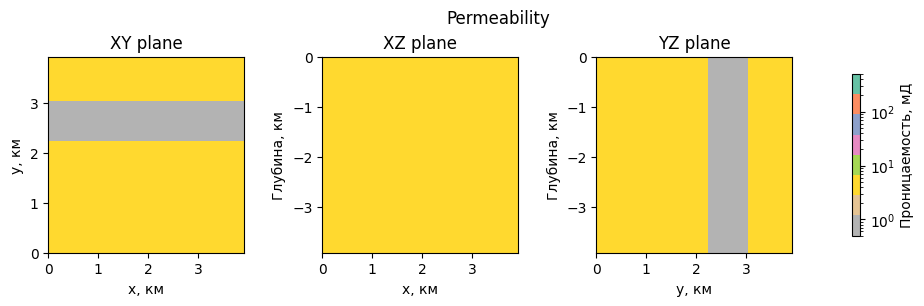

In [ ]:
# рисовалка проницаемости, стереть после использования

dx, dy, dz = 80, 80, 80
source_loc = (25, 25, 25)

fake_perm = np.ones((50, 50, 50)) * 10 # 10 миллидарси
fake_perm[...,28:38,:] = 500 # Очень большая проницаемая плоскость или
fake_perm[...,28:39,:] = 0.5 # Очень не проницаемая плоскость. Раскомментить нужное
downscaled_perm = fake_perm.astype('float32') # никто ничего не заметил

oneD_plot(ii, fake_perm, source_loc, dx, dy, dz, vmin_vmax=(0.5, 500), name='Permeability', saver=False)

  0%|          | 0/1 [00:00<?, ?it/s]

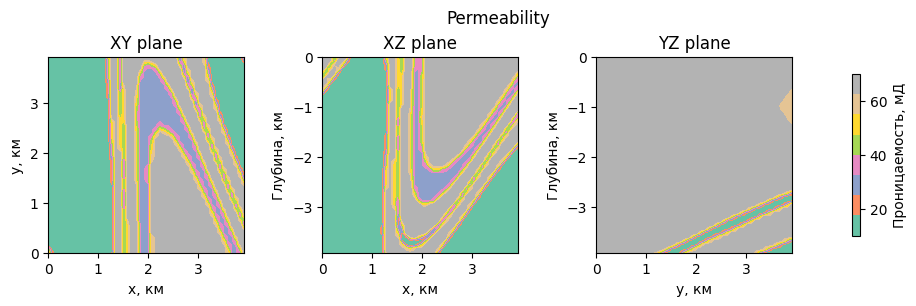

источник 5729746.936176985
хи 845.5


Output()

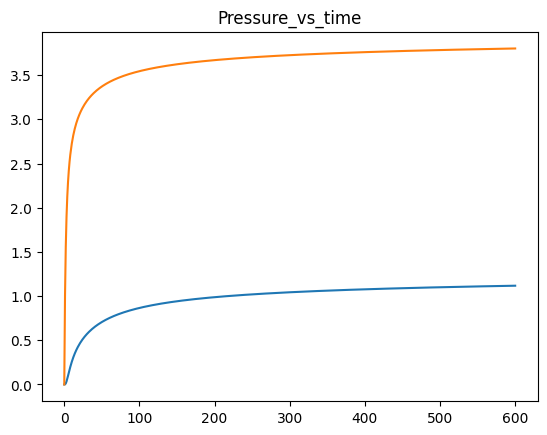

<ipython-input-88-1a80da2089b1>:83: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['points', 'side_lenght', 'downscale_factor', 'time_scale', 't_range',
       'dt', 'P0', 'Q', 'm0', 'mu', 'K_ro', 'K_m'],
      dtype='object')]




In [ ]:
# имя и путь для сохранения
pore_press_name = 'pore_press'
pore_press_path = f'{CURR_DIR}/{pore_press_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # готовим ссылку, чтобы было больше порядка

# параметры моделирования
# t_range меряется в единицах time_scale. То есть time_scale=3600 t_range=100 означет 100 часов с часовым шагом
params = BaseConfig(Q = 5, downscale_factor = (4,4,4), time_scale = 0.5*3600, t_range = 600, dt = 0.001)
dx, dy, dz = np.array(params.side_lenght)/ (params.points / params.downscale_factor[0])

# Количество моделей проницаемости вфайле
with h5py.File(perm_path, 'r') as f:
    nmodels = f['/perms'].shape[0]

# Итерируемся по файлку проницаемостей, считаем модель, сохраняем по одной на диск
for ii in tqdm(range(nmodels)):
    with h5py.File(perm_path, 'r') as src:
        perm = src['/perms'][ii] # проницаемолсти были во флоат 16

    downscaled_perm = downscale(perm, params.downscale_factor) # рескейлим модель

    '''
    Тут мы вставляем новую модельку из проницаемостей вместо старой
    <><><>><>><><><><><><><><><><><><><><><><><><><>><><><><><><><>             <<<<<<<========================================= Внимание!!! Тут! ==================================<<<<<<<<<<<<<<<<<<<<<<<<
    '''
    # fake_perm = np.ones_like(downscaled_perm) * 10 # 10 миллидарси
    # # fake_perm[...,28:38,:] = 500 # Очень большая проницаемая плоскость или
    # fake_perm[...,28:38,:] = 0.5 # Очень не проницаемая плоскость. Раскомментить нужное
    # downscaled_perm = fake_perm.astype('float32') # никто ничего не заметил
    '''
    дальше всё как обычно, но в ещё одном месте делаем другую плотность, чтобы литостатика не влияла И ещё определение локации скважини попорчено, см. выше!
    '''

    source_loc = source_location(downscaled_perm, params)

    #threeD_plot(downscaled_perm, 'Permeability')
    oneD_plot(ii, downscaled_perm, source_loc, dx, dy, dz, 'Permeability', saver=True)

    do_it_1 = find_pore_pressure_1(downscaled_perm, params) # моделируем поровое давление

    pressureInPoint_vs_time = []
    pressure_in_source = []
    for pressure_distrib in do_it_1.data:
      pressureInPoint_vs_time.append(pressure_distrib[source_loc[0]+1][source_loc[1]+1][source_loc[2]+1])
      pressure_in_source.append(pressure_distrib[source_loc[0]][source_loc[1]][source_loc[2]])
    plt.plot(pressureInPoint_vs_time)
    plt.plot(pressure_in_source)
    plt.title('Pressure_vs_time')
    # plt.savefig(f'pressure_vs_time_{ii}.png', dpi = 300,  bbox_inches='tight', transparent=False)
    plt.show()

    # oneD_plot(ii, do_it_1.data[0], source_loc, dx, dy, dz, 'Pore Pressure after 1 step', saver=False)
    # oneD_plot(ii, do_it_1.data[-1], source_loc, dx, dy, dz, 'Pore Pressure after last step', saver=False)

    # do_it_2 = find_pore_pressure_2(downscaled_perm, params) # моделируем поровое давление

    # pressureInPoint_vs_time = []
    # pressure_in_source = []
    # for pressure_distrib in do_it_2.data:
    #   pressureInPoint_vs_time.append(pressure_distrib[source_loc[0]+1][source_loc[1]+1][source_loc[2]+1])
    #   pressure_in_source.append(pressure_distrib[source_loc[0]][source_loc[1]][source_loc[2]])
    # plt.plot(pressureInPoint_vs_time)
    # plt.plot(pressure_in_source)
    # plt.title('Pressure_vs_time')
    # # plt.savefig(f'pressure_vs_time_{ii}.png', dpi = 300,  bbox_inches='tight', transparent=False)
    # plt.show()

    # oneD_plot(ii, do_it_2.data[0], source_loc, dx, dy, dz, 'Pore Pressure after 1 step with hydrostat', saver=False)
    # oneD_plot(ii, do_it_2.data[-1], source_loc, dx, dy, dz, 'Pore Pressure after last step with hydrostat', saver=False)

    # сейвим результаты одного расчёта
    # режим открытия "а": Read/write if exists, create otherwise
    with h5py.File(pore_press_path, 'a') as targ:
        if "pore_press" not in targ.keys():
            data = np.stack(do_it_1.data)
            targ.create_dataset("pore_press", (nmodels,) + data.shape, dtype='float16')

        pore_press = targ['/pore_press']
        data = np.stack(do_it_1.data) # делаем один массив из листа массивов
        pore_press[ii] = data.astype('float16')

# параметры сохранить
params_df = pd.DataFrame(pd.Series(params.__dict__)).T
params_df.to_hdf(pore_press_path, key = 'params')


In [ ]:
# и вот наш результат
with h5py.File(pore_press_path, 'r') as f:
    pore_press = f['/pore_press'][:]

loaded_params_df = pd.read_hdf(pore_press_path, '/params')

pore_press.shape

plt.scatter(range(50), pore_press[0,-1,25,25,:])
loaded_params_df.head()


## Черновой вариант моделирование сейсмичности (поровое давление учитывается при вычислении критерия Кулона-Мора, c учетом гидростатики)

In [ ]:
from matplotlib.colors import make_norm_from_scale
from scipy import stats

event_den_name = 'event_den'
event_den_path = f'{CURR_DIR}/{event_den_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
events_name = 'events'
events_path = f'{CURR_DIR}/{events_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
total_events_name = 'total_events'
total_events_path = f'{CURR_DIR}/{total_events_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
xi_source_name = 'xi_source'
xi_source_path = f'{CURR_DIR}/{xi_source_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
max_dist_name = 'max_dist'
max_dist_path = f'{CURR_DIR}/{max_dist_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
vect_max_dist_name = 'vect_max_dist'
vect_max_dist_path = f'{CURR_DIR}/{vect_max_dist_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
model_perm_average_name = 'model_perm_average'
model_perm_average_path = f'{CURR_DIR}/{model_perm_average_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
perm_source_name = 'perm_source'
perm_source_path = f'{CURR_DIR}/{perm_source_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка
source_location_name = 'source_location'
source_location_path = f'{CURR_DIR}/{source_location_name}_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.h5' # ссылка


def get_max_dist(ev_dens, location, mscale):
    indi_arr = np.transpose(np.indices(ev_dens[0].shape), (1,2,3,0))
    source_lll  = np.ones((50,50,50,1)) * location

    distances = np.sqrt(np.sum((indi_arr-source_lll)**2, axis=-1))

    time_dist = np.ones_like(ev_dens) * np.expand_dims(distances, 0)
    max_distance0 = np.max(time_dist[ev_dens>0],0) * mscale

    return max_distance0

def get_max_dist_in_time(ev_dens, location, mscale):
    indi_arr = np.transpose(np.indices(events_dens[0].shape), (1,2,3,0))
    source_lll  = np.ones((50,50,50,1)) * source_l
    distances = np.sqrt(np.sum((indi_arr-source_lll)**2, axis=-1))
    time_dist = np.ones_like(events_dens) * np.expand_dims(distances, 0)

    max_distance = np.array([])
    for i in range(time_dist.shape[0]):
        t_dist = time_dist[i]
        if len(t_dist[events_dens[i]>0]) == 0:
            max_distance = np.append(max_distance,0)
        else:
            max_distance = np.append(max_distance,np.max(t_dist[events_dens[i]>10e-8]) * 80)

    return max_distance

def seismic_events_fig(ev, tot_ev, ch_time, t_time, t_sc, t_r):
    # first figure
    fig, ax = plt.subplots(figsize=(4.33, 3), facecolor='white', constrained_layout=True)

    ax.grid(True)
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(0,t_r,50)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.array(range(0,t_r,50)) * t_sc / 3600))

    ax.tick_params(top=False, bottom=True, left = True, width=1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('black')

    plt.plot(ev/tot_ev)
    plt.savefig(f'Events_model_{nn}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    # second figure
    # fig1, ax1 = plt.subplots(figsize=(4.33, 3), facecolor='white', constrained_layout=True)

    # ax1.grid(True)
    # ax1.set_axisbelow(True)

    # ax1.tick_params(top=False, bottom=True, left = True, width=1)
    # for axis in ['top','bottom','left','right']:
    #     ax1.spines[axis].set_linewidth(1)
    #     ax1.spines[axis].set_color('black')

    # # plt.plot(ev)
    # # plt.plot(ev/tot_ev)
    # plt.plot(t_time/ch_time,ev/tot_ev)
    # plt.savefig(f'Events_model_specific_{nn}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    return






## seeds here

In [ ]:
# количество моделей, шагов по времени и размер одной модели
with h5py.File(pore_press_path, 'r') as f:
    nmodels = f['/pore_press'].shape[0]
    time_steps = f['/pore_press'].shape[1]
    model_shape = f['/pore_press'].shape[2:]

params_df = pd.read_hdf(pore_press_path, '/params') # параметры модели (если понадобятся)

NSAMPL = 200

'''
Делаем функцию для перевода направления трещины в вектор нормали
Функция берет азимут и наклон трещины и возвращает вектор нормали
Азимутом будем считать угол направления трещины в плоскости ХY (0 - 180 градусов) от оси X,
Наклоном - угол наклона относительно горизонтали (0 - 90 градусов, 0 - горизонтальная трещина)
'''
def get_norm_vector(azi, incl):
    # azi incl могут быть массивами
    nx = np.cos(np.pi/2 + azi) * np.cos(np.pi/2 + incl)
    ny = np.sin(np.pi/2 + azi) * np.cos(np.pi/2 + incl)
    nd = np.sin(np.pi/2 + incl)
    return np.stack((nx, ny, nd), axis=-1)

'''
Надо бы весь код привести к единому стандарту,
что куда у нас направленои как оси модели соотносятся со сторонами света
пока что получается, что вертикальная трещина в направлении оси Х
будет (azi = 0, incl = np.pi/2), а соответствующий ей вектор нармали (0.0, -1.0, 0.0)
у горизонтальной трещина нормаль смотрит вверх. Ну в общем, тут надо всё аккуратно проверить.
'''

'''
Задаём параметры распределений параметров (средние и стандартные отклонения). Потом их надо в общий обьект с параметрами добавить
'''
# для первой системы трещин - вертикальные трещины
azi_0 = np.pi/4 #  среднее направлеие первой трещиноватости
incl_0 = np.pi/2 # вертикальные трещины
azi_0_sigma = np.pi*5/180 # 5 градусов погрешности
incl_0_sigma = np.pi*5/180

tan_phi_0 = 0.83 # среднее значение тангенса фи
tan_phi_0_sigma = 0.025 * tan_phi_0 # стандартное отклонение тангенса фи

# C_0 = 1 # МПа когезия
# C_0_sigma = 0.1 # МПа

C_0 = 0.0 # МПа когезия
C_0_sigma = 0.01 # МПа

# для второй системы трещин - горизонтальных (чтобы задать бинормальное распределение трещин)
azi_1 = np.pi/4 #  среднее направлеие второй трещиноватости
incl_1 = np.pi/9 # почти горизонтальные трещины
azi_1_sigma = np.pi*5/180 # 5 градусов погрешности
incl_1_sigma = np.pi*5/180

tan_phi_1 = 0.83  # среднее значение тангенса фи, может быть другое по сравнению с ..._0, но пока такое же
tan_phi_1_sigma = 0.025 * tan_phi_0 # стандартное отклонение тангенса фи

# C_1 = 1 # МПа когезия
# C_1_sigma = 0.1 # МПа

C_1 = 0.0 # МПа когезия
C_1_sigma = 0.01 # МПа

'''
доля трещин первого типа frac_share
если frac_share = 0.6 то первых 60% вторых 40%
'''
frac_share = 0.5
NSAMPL_0 = int(frac_share * NSAMPL)
NSAMPL_1 = int((1-frac_share) * NSAMPL)

'''
Задаём распределения параметров
'''
tan_phi_distrib_0 = stats.weibull_min(loc=tan_phi_0, scale=tan_phi_0_sigma, c=1.8) # задаём распределение вейбулла с с=1.8 (надо выяснить какое лучше) тангенсов фи
C_distrib_0 = stats.weibull_min(loc=C_0, scale=C_0_sigma, c=1.8) # распределение вейбулла когезии
azi_distrib_0 = stats.norm(loc=azi_0, scale=azi_0_sigma) # нормальные распределения углов трещины
incl_distrib_0 = stats.norm(loc=incl_0, scale=incl_0_sigma)

tan_phi_distrib_1 = stats.weibull_min(loc=tan_phi_1, scale=tan_phi_1_sigma, c=1.8) # задаём распределение вейбулла с с=1.8 (надо выяснить какое лучше) тангенсов фи
C_distrib_1 = stats.weibull_min(loc=C_1, scale=C_1_sigma, c=1.8) # распределение вейбулла когезии
azi_distrib_1 = stats.norm(loc=azi_1, scale=azi_1_sigma) # нормальные распределения углов трещины
incl_distrib_1 = stats.norm(loc=incl_1, scale=incl_1_sigma)
'''
Сэмплируем по NSAMPL значений
'''
tan_phi_rvs_0 = tan_phi_distrib_0.rvs(size=model_shape+(NSAMPL_0,)).astype('float16')
C_rvs_0 = C_distrib_0.rvs(size=model_shape+(NSAMPL_0,)).astype('float16')
azi_rvs_0 = azi_distrib_0.rvs(size=model_shape+(NSAMPL_0,)).astype('float16')
incl_rvs_0 = incl_distrib_0.rvs(size=model_shape+(NSAMPL_0,)).astype('float16')
norms_rvs_0 = get_norm_vector(azi_rvs_0, incl_rvs_0) # Из последних двух делаем координаты нормали

tan_phi_rvs_1 = tan_phi_distrib_1.rvs(size=model_shape+(NSAMPL_1,)).astype('float16')
C_rvs_1 = C_distrib_1.rvs(size=model_shape+(NSAMPL_1,)).astype('float16')
azi_rvs_1 = azi_distrib_1.rvs(size=model_shape+(NSAMPL_1,)).astype('float16')
incl_rvs_1 = incl_distrib_1.rvs(size=model_shape+(NSAMPL_1,)).astype('float16')
norms_rvs_1 = get_norm_vector(azi_rvs_1, incl_rvs_1) # Из последних двух делаем координаты нормали

'''
конкатинируем их вместе, чтобы получились бинормально распределённые величины
'''
tan_phi = np.concatenate((tan_phi_rvs_0, tan_phi_rvs_1), axis=-1)
C = np.concatenate((C_rvs_0, C_rvs_1), axis=-1)
norms = np.concatenate((norms_rvs_0, norms_rvs_1), axis=-2)

dist_from_source = np.array([])
xi_source = np.array([])
model_perm_average = np.array([])
perm_source = np.array([])
total_events = np.array([])

# итерируемся по моделям
for nn in tqdm(range(nmodels)):
    with h5py.File(pore_press_path, 'r') as f:
        pore_press = f['/pore_press'][nn] # файлик с поровым давлением, подразумеваем что у него размерность (t,x,y,d) d - глубина

    with h5py.File(perm_path, 'r') as f:
        dens = f['/density'][nn]
        poisson = f['/poissons'][nn]
        perms = f['/perms'][nn]

    # модель напряжений в пласте с учетом увеличения давления с глубиной (по формуле Динника)

    model_perm_average = np.append(model_perm_average,np.mean(perms))
    perm_down = downscale(perms, params.downscale_factor)

    source_l = source_location(perm_down, params)

    xi_down = get_xi(perm_down,params)

    down_dens = downscale(dens, params.downscale_factor) * 1e-6 # рескейлим модель
    dens_average = np.mean(down_dens,axis=(0,1,2)) # осреднение плотности по всему массиву

    '''
    ВНИМАНИЕ !!!! ТУТ ТОЖЕ НАПОРЧЕНО!!! В ТРЕТЬЕМ МЕСТЕ         <<<<<<<<<<<<<<<<<<<<<<==================================== !!!!!! ===============================<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    '''
    # fake_dens = np.ones_like(down_dens) *  dens_average # какая то одинаковая плотность везде
    # down_dens = fake_dens
    '''
    досюда
    '''

    poisson = 0.3 # сделала константой
    poisson_const = poisson/(1-poisson)
    ro_fluid = 1000 #kg/m^3
    g = 9.82 #m/s^2
    depth_H = 0
    upper_rock_pressure = np.ones(pore_press[0].shape)*dens_average*g*depth_H

    # cum_rock_dens = np.flip(np.cumsum(down_dens,axis=2), -1) # кумулятивная сумма плотностей кг/м3 * 1e-6
    # cum_fluid_dens = np.flip(np.cumsum(np.ones_like(down_dens) * ro_fluid, axis=2), -1) * 1e-6 # кг/м3 * 1e-6
    cum_rock_dens = np.cumsum(down_dens,axis=2) # кумулятивная сумма плотностей кг/м3 * 1e-6
    cum_fluid_dens = np.cumsum(np.ones_like(down_dens) * ro_fluid, axis=2) * 1e-6 # кг/м3 * 1e-6
    lithostat_pressure = np.ones_like(down_dens) * cum_rock_dens * g * dz # МПа
    hydrostat_pressure = cum_fluid_dens * g * dz # МПа

    # sub_lit_hyd = lithostat_pressure - hydrostat_pressure

    hydrostat_pressure = np.ones_like(pore_press) * hydrostat_pressure
    pore_press2 = pore_press + hydrostat_pressure

    # oneD_plot(nn, pore_press2[0], source_l, dx, dy, dz, 'Pore Pressure after the first step (with hydrostatic pressure)', saver=False)
    # oneD_plot(nn, pore_press2[-1], source_l, dx, dy, dz, 'Pore Pressure after the last (with hydrostatic pressure)', saver=False)

    # OneD_plot2(nn, sub_lit_hyd, source_l, dx, dy, dz, vmin = np.min(sub_lit_hyd), vmax = np.max(sub_lit_hyd),
    #            cmap = mpl.cm.plasma, color_label ='', name='Градиент давлений', saver=False)


    point_tens = np.diag((poisson_const, poisson_const, 1)).astype('float16')
    tens = np.expand_dims((lithostat_pressure),(-2,-1)) * point_tens # размазываем тензор по модели, # размерность (x,y,d,3,3)

    vect = (np.expand_dims(tens,-3) @ np.expand_dims(norms,-1)).squeeze(-1)
    sigma_n = (np.expand_dims(vect,-2) @ np.expand_dims(norms,-1)).squeeze(-1) # нормальные напряги на трещинах

    vect2 = (np.expand_dims(vect, -2) @ np.expand_dims(vect, -1)).squeeze(-1) # квадраты
    sigma_n2 = sigma_n**2

    tau = np.sqrt(np.abs(vect2 - sigma_n2)) #касательные напряжения

    sigma_n = sigma_n.squeeze(-1) # размерность (x,y,d,NSAMPL)
    tau = tau.squeeze(-1) # размерность (x,y,d,NSAMPL)

    '''
    можно итерироваться по времени
    '''
    colomb_pass = np.zeros_like(pore_press2) # сюда будем класть результаты выполнения критерия Кулона
    for t, porepress_frame in enumerate(tqdm(pore_press2)):
        pore = np.expand_dims(porepress_frame, -1) # ему надодокинуть размерности, так как оно не семплированоб стало (x,y,d,1)
        '''
        Делаем распределение критерия Кулона F = tau - (sigma_n - pore) * tg_phi - C
        Вероятность события - это процент семплированных значений, больших нуля.
        '''
        alpha = 1 # коэффициент Био
        F = tau - (sigma_n - alpha * pore) * tan_phi - C
        colomb_pass[t] = (np.sum(F>0, axis=-1).astype('int') / NSAMPL).astype('float16') # вероятность, (x,y,d), если равно 1, значит все семплированные трещины выполинили критерий

        # количество событий будет вероятность, умножить на трещиноватость (сколько трещин в кубю метре) умножить на объём ячейки

    '''
    то, что посчитали в предыдущем цикле - это процент семплированных трещин, для которых выполнился критерий Кулона на каждом шаге.
    Чтобы смоделировать плотность именно событий, надо считать приращение этой величины (количество событий = количество сработавших трещин минус количество сработавших до этого)
    '''
    events_dens = np.zeros_like(pore_press2) # плотность событий размерность (t,x,y,d)
    events_dens[1:] = np.diff(colomb_pass, axis=0) # размерность (t,x,y,d)
    # количество событий в каждой ячейке будет events_dens, умножить на трещиноватость (сколько трещин в кубю метре) умножить на объём ячейки (отличается от NSAMPL)

    events = np.sum(events_dens, axis=(1,2,3)) # событий по всей модели на кадом шаге
    tot_events = np.sum(events)

    # total_events = np.append(total_events,tot_events)

    # OneD_plot3(nn, np.argmax(events == np.max(events)), events_dens, source_l, dx, dy, dz, vmin = None, vmax = None,
    #            cmap = mpl.cm.Oranges, color_label ='Event density', name='Density of seismic events (maximum)', saver=False)

    # cumsum_events = np.cumsum(events_dens, axis = 0)

    # OneD_plot3(nn, np.argmax(events == np.max(events)), cumsum_events, source_l, dx, dy, dz, vmin = None, vmax = None,
    #            cmap = mpl.cm.Oranges, color_label ='Event density', name='Cumulutive density of seismic events (maximum)', saver=False)


    # # oneD_plot(nn, events_dens[int(np.where(events == np.max(events))[0])], source_l, dx, dy, dz, 'Density of seismic events (maximum)', saver=True)
    # # Dens_plot(nn,perm_down, events_dens[int(np.where(events == np.max(events))[0])], source_l, dx, dy, dz, 'Density of seismic events (maximum)', saver=True)
    # Dens_plot(nn, np.argmax(events == np.max(events)), perm_down, events_dens, source_l, dx, dy, dz, 'Density of seismic events (maximum)', saver=True)

    # xi_source = np.append(xi_source,xi_down[source_l[0]][source_l[1]][source_l[2]])
    # perm_source = np.append(perm_source,perm_down[source_l[0]][source_l[1]][source_l[2]])
    # character_time = (params.side_lenght[0] ** 2) / xi_down[source_l[0]][source_l[1]][source_l[2]]# характерное время установки стационарного режима течения L^2/xi, L=4000м, xi=xi(source_loc)
    # tot_time = np.arange(0,params.t_range + 1,1)  * params.time_scale  / character_time # относительное время в секундах

    # # оформление графика
    # seismic_events_fig(ev = events, tot_ev = tot_events, ch_time = character_time, t_time = tot_time, t_sc = params.time_scale, t_r = params.t_range)

    # scalingm = params.side_lenght[0] / params.points * params.downscale_factor[0]

    # # определение максимального расстояния сейсмического события от источника
    # DIST_MAX = get_max_dist(events_dens, location=source_l, mscale = scalingm)
    # print(f'Максимальное расстояния сейсмического события от источника {int(DIST_MAX)}')

    # dist_from_source = np.append(dist_from_source,DIST_MAX)

    # vect_d_max = get_max_dist_in_time(events_dens, location=source_l, mscale = scalingm)

    # if nn == 0:
    #     VECT_dist_max = np.zeros((nmodels,) + events.shape)
    #     VECT_dist_max[nn] = vect_d_max

    # VECT_dist_max[nn] = vect_d_max

    # if nn == 0:
    #     DATA_events_dens = np.zeros((nmodels,) + events_dens.shape)
    #     DATA_events_dens[nn] = events_dens

    # DATA_events_dens[nn] = events_dens

    # if nn == 0:
    #     DATA_events = np.zeros((nmodels,) + events.shape)
    #     DATA_events[nn] = events

    # DATA_events[nn] = events

# print(f'xi в точке источника для всех моделей {xi_source}')
# print(f'Общее количество сейсмических событий для всех моделей {total_events}')
# print(f'Вектор максимальных расстояний сейсмических событий от источника для всех моделей {dist_from_source}')

# with h5py.File(event_den_path, 'a') as f:
#     f.create_dataset('event_den',data = DATA_events_dens)

# with h5py.File(events_path, 'a') as f:
#     f.create_dataset('events',data = DATA_events)

# with h5py.File(total_events_path, 'a') as f:
#     f.create_dataset('total_events',data = total_events)

# with h5py.File(xi_source_path, 'a') as f:
#     f.create_dataset('xi_source',data = xi_source)

# with h5py.File(max_dist_path, 'a') as f:
#     f.create_dataset('max_dist',data = dist_from_source)

# with h5py.File(vect_max_dist_path, 'a') as f:
#     f.create_dataset('vect_max_dist',data = VECT_dist_max)

# with h5py.File(model_perm_average_path, 'a') as f:
#     f.create_dataset('model_perm_average',data = model_perm_average)

# with h5py.File(perm_source_path, 'a') as f:
#     f.create_dataset('perm_source',data = perm_source)

# with h5py.File(source_location_path, 'a') as f:
#     f.create_dataset('source_location',data = source_l)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

### Рисование всего


In [ ]:
colomb_pass[600,25,25]

array([0.1899414 , 0.22998047, 0.20996094, 0.1850586 , 0.19995117,
       0.22998047, 0.19494629, 0.20495605, 0.22497559, 0.16003418,
       0.19995117, 0.22497559, 0.22998047, 0.14501953, 0.2199707 ,
       0.17004395, 0.1899414 , 0.20495605, 0.1850586 , 0.23498535,
       0.26489258, 0.23999023, 0.22998047, 0.2800293 , 0.27490234,
       0.26489258, 0.19995117, 0.27490234, 0.24499512, 0.2548828 ,
       0.18005371, 0.17504883, 0.21496582, 0.21496582, 0.23498535,
       0.21496582, 0.19995117, 0.17504883, 0.22497559, 0.2199707 ,
       0.1850586 , 0.20495605, 0.15002441, 0.21496582, 0.2199707 ,
       0.18005371, 0.22998047, 0.17504883, 0.23498535, 0.20495605],
      dtype=float32)

In [ ]:
# рисовалка срезов
def plot_3pic(array, source_location, ddx, ddy, ddz, time_moment=None, vmin=None, vmax=None, cmap=None, color_label='unnamed', model_number=0, name='unnamed', save_path=None):

    if (vmin == None) & (vmax == None):
        vmin = np.min(array)
        vmax = np.max(array)

    if not cmap:
        cmap = mpl.cm.Set2

    norm = mpl.colors.Normalize(vmin, vmax)

    if time_moment:
        matrix = array[time_moment]
    else:
        matrix = array

    N_x, N_y, N_z = matrix.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    fig.suptitle(name)

    ax1.contourf(x_graph, y_graph, matrix[:, :, source_location[2]].transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, matrix[:, source_location[1], :].transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, matrix[source_location[0], :, :].transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)

    if save_path:
        plt.savefig(f'{save_path}/{model_number}_{name}.png', dpi = 300,  bbox_inches='tight', transparent=False)
        plt.close()
    else:
        plt.show()

# рисовалка с суммированием
def plot_3pic_sum(array, source_location, ddx, ddy, ddz, time_moment=None, vmin=None, vmax=None, cmap=None, color_label='unnamed', model_number=0, name='unnamed', save_path=None):

    if (vmin == None) & (vmax == None):
        vmin = np.min(array)
        vmax = np.max(array)

    if not cmap:
        cmap = mpl.cm.Set2

    norm = mpl.colors.Normalize(vmin, vmax)

    if time_moment:
        matrix = array[time_moment]
    else:
        matrix = array

    N_x, N_y, N_z = matrix.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4,hspace=0.1)
    fig.suptitle(name)

    ax1.contourf(x_graph, y_graph, np.sum(matrix, axis=2).transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, км')
    ax1.set_ylabel('y, км')

    ax2.contourf(x_graph, z_graph, np.sum(matrix, axis=1).transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax2.set_title('XZ plane')
    ax2.set_aspect('equal')
    ax2.set_xlabel('x, км')
    ax2.set_ylabel('Глубина, км')

    ax3.contourf(y_graph, z_graph, np.sum(matrix, axis=0).transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=(ax1, ax2, ax3), anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)
    if save_path:
        plt.savefig(f'{save_path}/{model_number}_{name}.png', dpi = 300,  bbox_inches='tight', transparent=False)
        plt.close()
    else:
        plt.show()

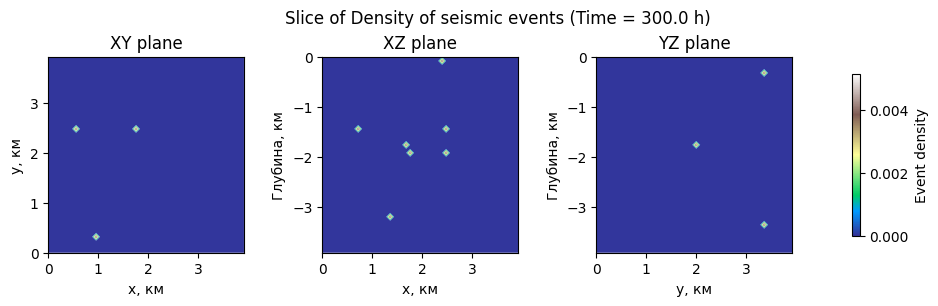

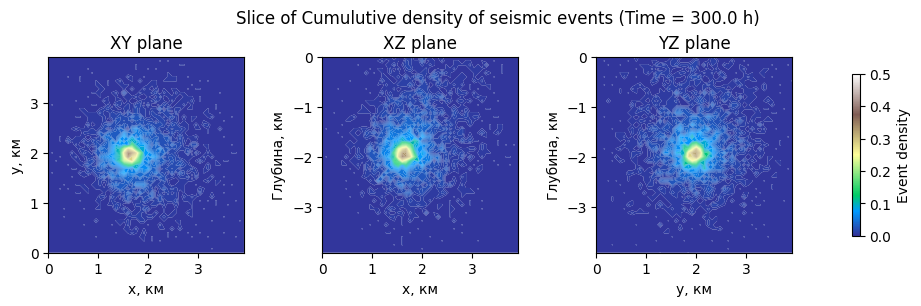

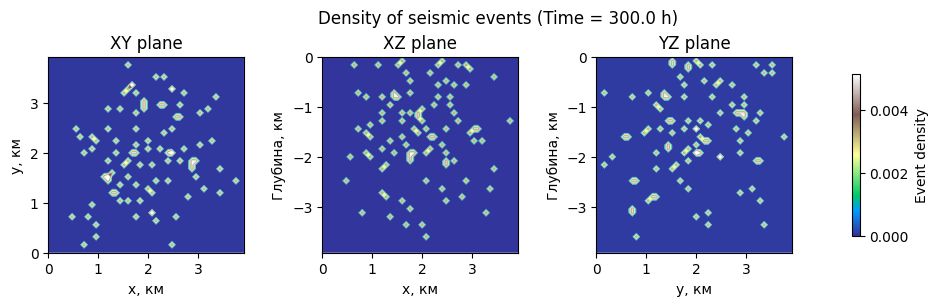

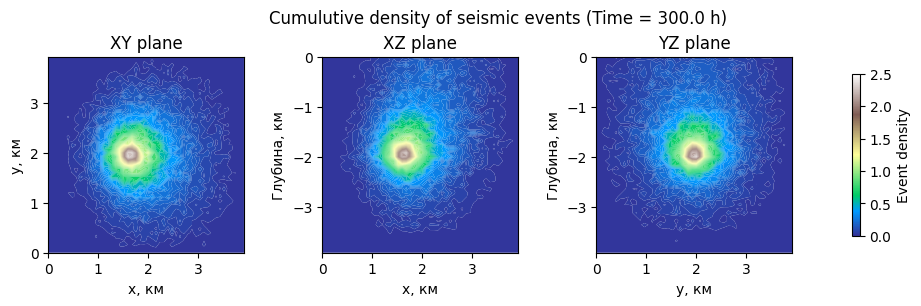

In [ ]:
# рисуем картинки в последний момент времени/в максимуме евентс
cmap = mpl.cm.terrain

# from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# # cmap = mpl.cm.winter

# winter = mpl.colormaps['winter'].resampled(256)
# newcolors = winter(np.linspace(0, 1, 256))
# darkblue2 = np.array([0/256, 0/256, 216/256, 1])
# newcolors[16:25, :] = darkblue2
# darkblue1 = np.array([0/256, 0/256, 190/256, 1])
# newcolors[6:15, :] = darkblue1
# darkblue = np.array([0/256, 0/256, 190/256, 1])
# newcolors[:5, :] = darkblue
# springgreen2 = np.array([0/256, 255/256, 148/256, 1])
# newcolors[251:256, :] = springgreen2

# newcmp = ListedColormap(newcolors)

# cmap = newcmp

# ii = int(np.where(events == np.max(events))[0])
ii = len(events) - 1
time_hors = ii*params.time_scale/3600

cumsum_events = np.cumsum(events_dens,axis = 0)

plot_3pic(events_dens[ii], source_l, dx, dy, dz,
          cmap = cmap, color_label ='Event density', name=f'Slice of Density of seismic events (Time = {time_hors} h)')

plot_3pic(cumsum_events[ii], source_l, dx, dy, dz, vmin=0, vmax=0.5,
            cmap = cmap, color_label ='Event density', name=f'Slice of Cumulutive density of seismic events (Time = {time_hors} h)')


# Суммарные по размерностям

plot_3pic_sum(events_dens[ii], source_l, dx, dy, dz,
          cmap = cmap, color_label ='Event density', name=f'Density of seismic events (Time = {time_hors} h)')

plot_3pic_sum(cumsum_events[ii], source_l, dx, dy, dz, vmin=0, vmax=2.5,
            cmap = cmap, color_label ='Event density', name=f'Cumulutive density of seismic events (Time = {time_hors} h)')

Text(0, 0.5, 'Нормированное количество событий')

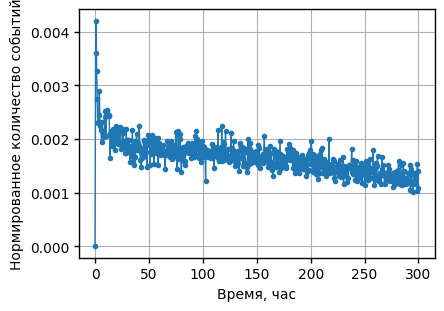

In [ ]:
# события от времени
fig, ax = plt.subplots(figsize=(4.33, 3), facecolor='white', constrained_layout=True)

ax.grid(True)
ax.set_axisbelow(True)

ax.tick_params(top=False, bottom=True, left = True, width=1)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
    ax.spines[axis].set_color('black')

x = params.time_scale*np.arange(events.shape[0])/3600
plt.plot(x, events/np.sum(events), marker='.', linewidth=1)
ax.set_xlabel('Время, час')
ax.set_ylabel('Нормированное количество событий')

Text(0.5, 0.92, 'Вектора нормали')

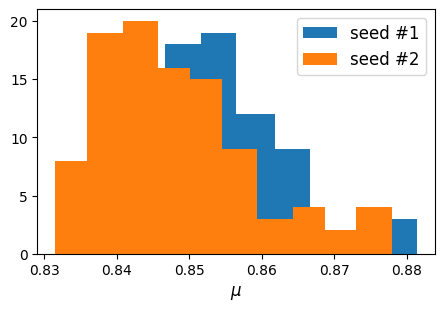

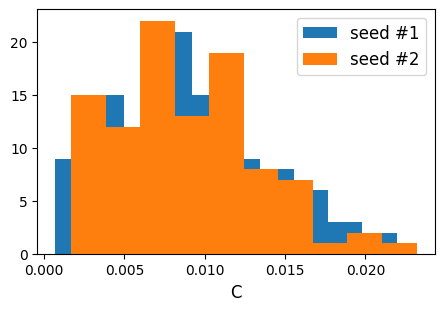

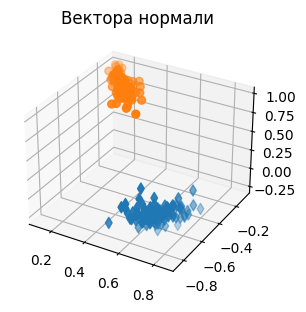

In [ ]:
# гистограммки

# tan_phi_rvs_0
# C_rvs_0
# azi_rvs_0
# norms_rvs_0

# tan_phi_rvs_1
# C_rvs_1
# azi_rvs_1
# norms_rvs_1

# распределение тангенс фи
fig, ax = plt.subplots(figsize=(4.33, 3), facecolor='white', constrained_layout=True)
ax.hist(tan_phi_rvs_0[25,25,25], label='seed #1')
ax.hist(tan_phi_rvs_1[25,25,25], label='seed #2')
ax.set_xlabel(r'$\mu$', fontsize=12)
ax.legend(fontsize=12)

# распределение С
fig, ax = plt.subplots(figsize=(4.33, 3), facecolor='white', constrained_layout=True)
ax.hist(C_rvs_0[25,25,25], label='seed #1')
ax.hist(C_rvs_1[25,25,25], label='seed #2')
ax.set_xlabel('C', fontsize=12)
ax.legend(fontsize=12)

# распределение векторов нормали
fig = plt.figure(figsize=(4.33, 3), facecolor='white', constrained_layout=True)
ax = fig.add_subplot(projection='3d')

xs, ys, zs = norms_rvs_0[25,25,25,:,0], norms_rvs_0[25,25,25,:,1], norms_rvs_0[25,25,25,:,2]
ax.scatter(xs, ys, zs , marker='d', s=32, label='seed #1')

xs, ys, zs = norms_rvs_1[25,25,25,:,0], norms_rvs_1[25,25,25,:,1], norms_rvs_1[25,25,25,:,2]
ax.scatter(xs, ys, zs , marker='o', s=32, label='seed #2')

ax.set_title('Вектора нормали', fontsize=12)
# ax.legend(fontsize=12)


## картинки для мультика

In [ ]:
# рисовалка только вертикального среза
def yz_plot_3pic(arr, source_location, ddx, ddy, ddz, time_moment=None, vmin=None, vmax=None, cmap=None, color_label='unnamed', model_number=0, name='unnamed', save_path=None):

    if (vmin == None) & (vmax == None):
        vmin = np.min(arr)
        vmax = np.max(arr)

    if not cmap:
        cmap = mpl.cm.Set2

    norm = mpl.colors.Normalize(vmin, vmax)

    if time_moment:
        matrix = arr[time_moment]
    else:
        matrix = arr

    N_x, N_y, N_z = matrix.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, ax3 = plt.subplots(1, 1, figsize=(4, 3))
    # plt.subplots_adjust(wspace=0.4,hspace=1)
    fig.suptitle(name)

    ax3.contourf(y_graph, z_graph, matrix[source_location[0], :, :].transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    # ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax3, anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)

    if save_path:
        plt.savefig(f'{save_path}/{model_number}_{name}.png', dpi = 300,  bbox_inches='tight', transparent=False)
        plt.close()
    else:
        plt.show()

# рисовалка с суммированием только вертикального среза
def yz_plot_3pic_sum(arr, source_location, ddx, ddy, ddz, time_moment=None, vmin=None, vmax=None, cmap=None, color_label='unnamed', model_number=0, name='unnamed', save_path=None):

    if (vmin == None) & (vmax == None):
        vmin = np.min(arr)
        vmax = np.max(arr)

    if not cmap:
        cmap = mpl.cm.Set2

    norm = mpl.colors.Normalize(vmin, vmax)

    if time_moment:
        matrix = arr[time_moment]
    else:
        matrix = arr

    N_x, N_y, N_z = matrix.shape

    x_graph = ddx * np.arange(N_x)/1000 # в километрах
    y_graph = ddy * np.arange(N_y)/1000
    z_graph =  - ddz * np.arange(N_z)/1000

    fig, ax3 = plt.subplots(1, 1, figsize=(4, 3))
    # plt.subplots_adjust(wspace=0.4,hspace=1)
    fig.suptitle(name)

    ax3.contourf(y_graph, z_graph, np.sum(matrix, axis=0).transpose(),
                 linewidths = None, levels=100, cmap = cmap, norm = norm, antialiased=True)
    # ax3.set_title('YZ plane')
    ax3.set_aspect('equal')
    ax3.set_xlabel('y, км')
    ax3.set_ylabel('Глубина, км')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax3, anchor=(0.1, 0.5), shrink=0.7, orientation='vertical', label=color_label)
    if save_path:
        plt.savefig(f'{save_path}/{model_number}_{name}.png', dpi = 300,  bbox_inches='tight', transparent=False)
        plt.close()
    else:
        plt.show()

In [ ]:
# подключаем гугл драйв
# (оно предложит пройти авторизацию и дать разрешения, после этого появится соответствующая папка)
from google.colab import drive
import os
drive.mount('/content/gdrive')

# создаём папку
base_folder = 'some_model'
my_path = "gdrive/MyDrive/"+f'{base_folder}'
os.mkdir("gdrive/MyDrive/"+f'{base_folder}')


Mounted at /content/gdrive


In [ ]:
# рисуем и сохраняем на диск каждую step картинку
cmap = mpl.cm.terrain

step = 5
cumsum_events = np.cumsum(events_dens,axis = 0)

for ii, tm in enumerate(tqdm(events_dens[::step])):
    time_hors = step*ii*params.time_scale/3600

    # Срезы
    plot_3pic(tm, source_l, dx, dy, dz, vmin=0, vmax=0.005,
              cmap = cmap, color_label ='Event density', name=f'Slice of density (Time = {time_hors} h)',  save_path=my_path)

    plot_3pic(cumsum_events[step*ii], source_l, dx, dy, dz, vmin=0, vmax=0.5,
                cmap = cmap, color_label ='Event density', name=f'Slice of cumulutive density (Time = {time_hors} h)', save_path=my_path)


    # Суммарные по размерностям
    plot_3pic_sum(tm, source_l, dx, dy, dz, vmin=0, vmax=0.005,
              cmap = cmap, color_label ='Event density', name=f'density (Time = {time_hors} h)', save_path=my_path)

    plot_3pic_sum(cumsum_events[step*ii], source_l, dx, dy, dz, vmin=0, vmax=2.5,
                cmap = cmap, color_label ='Event density', name=f'Cumulutive density (Time = {time_hors} h)', save_path=my_path)


  0%|          | 0/121 [00:00<?, ?it/s]

[25, 25, 25]